In [1]:
import numpy as np
import pandas as pd
import datetime
import time
import gc
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns
import lightgbm          as lgb
from   sklearn.model_selection import StratifiedKFold
from   sklearn.metrics import mean_squared_error
from   scipy.stats import ks_2samp
from bayes_opt import BayesianOptimization
import utils
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

In [2]:
df_train                 = pd.read_pickle("../data/input/train_test/train_final.pkl")
df_test                  = pd.read_pickle("../data/input/train_test/test_final.pkl")


significant_features     = utils.load_obj("significant_features")

In [3]:
train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
train_columns = [c for c in train_columns    if c in significant_features]

X_train       = df_train[train_columns]
target        = df_train['target']

In [4]:
def discard_different_features(df_train,df_test,train_columns):
    
    list_p_value =[]
    new_train_columns = []
    for i in train_columns:
        if df_test[i].dtypes != 'object':
            new_train_columns.append(i)
            list_p_value.append(ks_2samp(df_test[i] , df_train[i])[1])

    Se = pd.Series(list_p_value, index = new_train_columns).sort_values() 
    list_discarded = list(Se[Se < .1].index)
    
    return list_discarded

In [5]:
column_discarded = discard_different_features(df_train,df_test,train_columns)
train_columns    = [c for c in train_columns if c not in column_discarded] 

In [6]:
def model_training(df_train, df_test, target, param, train_columns, n_splits=5, save_oof = False):
    
    folds                 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    predictions           = np.zeros(len(df_test))
    feature_importance_df = pd.DataFrame()
    oof                   = np.zeros(df_train.shape[0])
    
    for fold_, (train_idx, valid_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
        print("fold {}".format(fold_))
        train_data = lgb.Dataset(df_train.iloc[train_idx][train_columns], 
                                 label=target.iloc[train_idx])#, categorical_feature=categorical_feats)
        valid_data = lgb.Dataset(df_train.iloc[valid_idx][train_columns], 
                                 label=target.iloc[valid_idx])#, categorical_feature=categorical_feats)

        num_round      = 10000
        clf            = lgb.train(param, train_data, num_round,
                                   valid_sets = [train_data, valid_data],
                                   verbose_eval=100, early_stopping_rounds = 100)
        
        
        oof[valid_idx] = clf.predict(df_train.iloc[valid_idx][train_columns],
                                     num_iteration=clf.best_iteration)
    
        fold_importance_df                 = pd.DataFrame()
        fold_importance_df["Feature"]      = train_columns
        fold_importance_df["importance"]   = clf.feature_importance()
        fold_importance_df["fold"]         = fold_ + 1
        feature_importance_df              = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(df_test[train_columns],
                                   num_iteration=clf.best_iteration) / folds.n_splits
        
        print(np.sqrt(mean_squared_error(oof, target)))
        
    if save_oof:
        oof_df = pd.DataFrame({"card_id":df_train["card_id"].values})
        oof_df["target"] = oof
        oof_file = "../data/output/oof_files/lgb_quarterly_submission"
        utils.to_pickles(oof_df, oof_file, split_size = 5, inplace=True)
        
    return predictions

In [7]:
def log_loss(actual,predicted):
    predicted     = list(map(lambda x: max(0.0001,x),predicted))
    not_predicted = list(map(lambda x: max(0.0001,1-x),predicted))
    return -((actual.dot(np.log(predicted))+(1 - actual).dot(np.log(not_predicted))))/len(actual)

## Bayesian optimization for hyperparameter

In [8]:
def LGB_CV_CLASS(    
                 num_leaves,
                 max_depth,
                 min_child_weight,
                 subsample,
                 subsample_freq,
                 colsample_bytree,
                 reg_alpha,       
                 reg_lambda,
                 n_estimators,
                 learning_rate,
                 min_data_in_leaf
                ):
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    oof   = np.zeros(df_train.shape[0])
    target = df_train['outliers']
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
        
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns],
                               label=target.iloc[trn_idx])
        
        val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns],
                               label=target.iloc[val_idx])
    
        param = {
                'objective'        : 'binary',
                "boosting"         : "gbdt",
                'num_leaves'       : int(num_leaves),
                'max_depth'        : int(max_depth),
                "min_child_weight" : min_child_weight,
                'min_data_in_leaf' : int(min_data_in_leaf), 
                "subsample"        : subsample,
                "subsample_freq"   : int(subsample_freq), 
                "colsample_bytree" : colsample_bytree,
                "reg_alpha"        : reg_alpha,
                "reg_lambda"       : reg_lambda,
                "n_estimators"     : int(n_estimators),
                'learning_rate'    : learning_rate,
                "metric"           : 'binary_logloss',            
                "verbosity"        : -1,
                'random_state'     : 0}

        clf = lgb.train(param,
                        trn_data,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500)
        
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns],
                                   num_iteration=clf.best_iteration)
        
        del clf, trn_idx, val_idx
        gc.collect()
        
    #actual     = target
    #predicted  = oof
    
    #predicted     = list(map(lambda x: max(0.0001,x),predicted))
    #not_predicted = list(map(lambda x: max(0.0001,1-x),predicted))

    #return -((actual.dot(np.log(predicted))+(1 - actual).dot(np.log(not_predicted))))/len(actual)
    return log_loss(target,oof)

In [8]:
def LGB_CV_REG(    
                 num_leaves,
                 max_depth,
                 min_child_weight,
                 subsample,
                 subsample_freq,
                 colsample_bytree,
                 reg_alpha,       
                 reg_lambda,
                 n_estimators,
                 learning_rate,
                 min_data_in_leaf
                ):
    
    folds  = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    oof    = np.zeros(df_train.shape[0])
    target = df_train['target']
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
        
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns],
                               label=target.iloc[trn_idx])
        
        val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns],
                               label=target.iloc[val_idx])
    
        param = {
                'objective'            : 'regression',
                "boosting"             : "gbdt",
                'num_leaves'           : int(num_leaves),
                'max_depth'            : int(max_depth),
                "min_child_weight"     : min_child_weight,
                'min_data_in_leaf'     : int(min_data_in_leaf), 
                "subsample"            : subsample,
                "subsample_freq"       : int(subsample_freq), 
                "colsample_bytree"     : colsample_bytree,
                "reg_alpha"            : reg_alpha,
                "reg_lambda"           : reg_lambda,
                "n_estimators"         : int(n_estimators),
                'learning_rate'        : learning_rate,
                "metric"               : 'rmse',            
                "verbosity"            : -1,
                'random_state'         : 0}
    
        clf = lgb.train(param,
                        trn_data,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 100)
        
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns],
                                   num_iteration=clf.best_iteration)
        
        del clf, trn_idx, val_idx
        gc.collect()
        
    
    return -mean_squared_error(oof, target)**0.5

In [9]:
LGB_BO_CLASS = BayesianOptimization(LGB_CV_CLASS, {
                                      'num_leaves'       : (10,80),
                                      'max_depth'        : (3,10),
                                      'min_child_weight' : (1,60),
                                      'subsample'        : (0.4,1),
                                      'subsample_freq'   : (0,20),
                                      'colsample_bytree' : (0.4,1),
                                      'reg_alpha'        : (0,10),       
                                      'reg_lambda'       : (1,40),
                                      'n_estimators'     : (50, 1000),
                                     'learning_rate'     : (0.008,0.4),
                                      'min_data_in_leaf' : (5,50)
                                      })

In [10]:
LGB_BO_REG = BayesianOptimization(LGB_CV_REG, {
                                      'num_leaves'       : (10,80),
                                      'max_depth'        : (3,10),
                                      'min_child_weight' : (1,60),
                                      'subsample'        : (0.4,1),
                                      'subsample_freq'   : (0,20),
                                      'colsample_bytree' : (0.4,1),
                                      'reg_alpha'        : (0,10),       
                                      'reg_lambda'       : (1,40),
                                      'n_estimators'     : (50, 1000),
                                     'learning_rate'     : (0.008,0.4),
                                      'min_data_in_leaf' : (5,50)
                                      })

In [11]:
print('-'*100)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO_REG.maximize(init_points=2, n_iter=100, acq='ei', xi=0.0)


----------------------------------------------------------------------------------------------------
Initialization
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   learning_rate |   max_depth |   min_child_weight |   min_data_in_leaf |   n_estimators |   num_leaves |   reg_alpha |   reg_lambda |   subsample |   subsample_freq | 
fold n°0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[33]	training's rmse: 3.47112	valid_1's rmse: 3.68243
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[27]	training's rmse: 3.49269	valid_1's rmse: 3.69286
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[40]	training's 

In [10]:
print('-'*100)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO_CLASS.maximize(init_points=2, n_iter=100, acq='ei', xi=0.0)

----------------------------------------------------------------------------------------------------
Initialization
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   learning_rate |   max_depth |   min_child_weight |   min_data_in_leaf |   n_estimators |   num_leaves |   reg_alpha |   reg_lambda |   subsample |   subsample_freq | 
fold n°0
[500]	training's binary_logloss: 0.024718	valid_1's binary_logloss: 0.0496977
fold n°1
[500]	training's binary_logloss: 0.0241472	valid_1's binary_logloss: 0.0530204
fold n°2
[500]	training's binary_logloss: 0.0248695	valid_1's binary_logloss: 0.0497375
fold n°3
[500]	training's binary_logloss: 0.0244284	valid_1's binary_logloss: 0.0494441
fold n°4
[500]	training's binary_logloss: 0.0240889	valid_1's binary_logloss: 0.049977
    1 |

In [11]:
LGB_BO_CLASS.res['max']['max_params']


{'num_leaves': 23.139822370824557,
 'max_depth': 8.58975375654246,
 'min_child_weight': 2.7078843623515434,
 'subsample': 0.45759536703648757,
 'subsample_freq': 15.291177856629368,
 'colsample_bytree': 0.48711283395859273,
 'reg_alpha': 0.4370945570821483,
 'reg_lambda': 1.8421506357456277,
 'n_estimators': 769.7003729230836,
 'learning_rate': 0.3824725368523456,
 'min_data_in_leaf': 9.218152218008113}

In [13]:
LGB_BO_REG.res['max']['max_params']

{'num_leaves': 69.73996492517938,
 'max_depth': 5.032821749635573,
 'min_child_weight': 58.72169981385353,
 'subsample': 0.7743352484347494,
 'subsample_freq': 10.531453984618025,
 'colsample_bytree': 0.6079607673654336,
 'reg_alpha': 1.2516468359917554,
 'reg_lambda': 39.91422683261549,
 'n_estimators': 984.4508643679893,
 'learning_rate': 0.04440594033746144,
 'min_data_in_leaf': 11.700552265707564}

In [ ]:
##feature importance second run
|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_da... | n_esti... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
|  7        | -3.66     |  0.8727   |  0.05846  |  8.699    |  59.03    |  48.36    |  452.2    |  22.46    |  8.395    |  37.98    |  0.8392   |  19.5     |

In [ ]:
##feature importance first run

|   iter    |  target   | baggin... | featur... | lambda_l1 | max_depth | min_da... | num_le... |
----------------------------------------------------------------------------------------------------
|  12       | -3.668    |  0.8084   |  0.873    |  5.776    |  9.835    |  148.2    |  127.2    |
|  15       | -3.668    |  0.7809   |  0.7033   |  5.737    |  9.985    |  139.9    |  129.7    |
|  21       | -3.668    |  0.8291   |  0.7406   |  5.703    |  9.981    |  148.4    |  129.4    |
|  22       | -3.668    |  0.8226   |  0.7462   |  5.99     |  9.719    |  147.2    |  129.7    |

## final model with above parameters.

In [22]:
param = {'num_leaves': round(78.8550248827644,0),
         'max_depth': round(4.364837032978728,0),
         'min_child_weight': 2.510726551117959,
         'subsample': 0.6195251212654296,
         'subsample_freq': round(1.3405825234524915,0),
         'colsample_bytree': 0.5400026592586313,
         'reg_alpha': 6.834814893383772,
         'reg_lambda': 35.35979905337201,
         'n_estimators': round(985.0790468368917,0),
         'learning_rate': 0.19687878426596275,
         'min_data_in_leaf': round(5.372504907365297,0)}

param = {
            'objective':'regression',
            "boosting": "gbdt",            
            "metric": 'rmse',            
            "verbosity": -1,
            'random_state' : 0
        }

In [23]:
predictions = model_training(df_train,df_test,target,param,train_columns,n_splits=5)

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.29727	valid_1's rmse: 3.67459
[200]	training's rmse: 3.13701	valid_1's rmse: 3.67922
Early stopping, best iteration is:
[103]	training's rmse: 3.29202	valid_1's rmse: 3.67431
3.829673703921456
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.28623	valid_1's rmse: 3.68435
Early stopping, best iteration is:
[90]	training's rmse: 3.30664	valid_1's rmse: 3.68239
3.7917227889271192
fold 2
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.30367	valid_1's rmse: 3.65784
[200]	training's rmse: 3.1412	valid_1's rmse: 3.66522
Early stopping, best iteration is:
[119]	training's rmse: 3.267	valid_1's rmse: 3.65756
3.75113603255225
fold 3
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.29077	valid_1's rmse: 3.68002
Early stopping, best iteration is:
[65]	training's rmse: 3.37182	valid

In [22]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("../result/BO_second_submission.csv", index=False)
best_sub = "../result/BO_second_submission.csv"

### new package

In [11]:
from GPyOpt.methods import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [38]:
# Optimization objective 
def LGB_CV(parameters):
    
#0     num_leaves, 
#1    max_depth, 
#2    min_child_weight,
#3    subsample,
#4    subsample_freq,
#5    colsample_bytree,
#6    reg_alpha,       
#7    reg_lambda,
#8    n_estimators,
#9    learning_rate,
#10    min_data_in_leaf

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    oof = np.zeros(df_train.shape[0])
    parameter = parameters[0]
#     boost = ['gbdt','goss','rf','dart']

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns],
                               label=target.iloc[trn_idx])
        
        val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns],
                               label=target.iloc[val_idx])
    
        param = {
            'objective':'regression',
            "boosting":"gbdt", #boost[parameter[11]],
            
            'num_leaves': int(parameter[0]),
            'max_depth': int(parameter[1]),
            "min_child_weight" : parameter[2], 
            "subsample" : parameter[3],
            "subsample_freq" : int(parameter[4]), 
            "colsample_bytree" : parameter[5],
            "reg_alpha": parameter[6],
            "reg_lambda" : parameter[7],
            "n_estimators" : int(parameter[8]),
            'learning_rate': parameter[9],
            'min_data_in_leaf': int(parameter[10]),
            
            "metric": 'rmse',            
            "verbosity": -1,
            'random_state' : 0
        }
    
        clf = lgb.train(param,
                        trn_data,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 100)
        
        oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns],
                                   num_iteration=clf.best_iteration)
        
        del clf, trn_idx, val_idx
        gc.collect()
        
    return -mean_squared_error(oof, target)**0.5

In [ ]:
bds = [{'name': 'num_leaves', 'type': 'discrete', 'domain': (3, 100)},
       {'name': 'max_depth', 'type': 'discrete', 'domain': (3, 50)},
       {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 60)},
       {'name': 'subsample', 'type': 'continuous', 'domain': (0, 1)},
       {'name': 'subsample_freq', 'type': 'discrete', 'domain': (3, 100)},
       {'name': 'colsample_bytree', 'type': 'continuous', 'domain': (0, 1)},
       {'name': 'reg_alpha', 'type': 'continuous', 'domain': (0, 10)},
       {'name': 'reg_lambda', 'type': 'continuous', 'domain': (1, 40)},
       {'name': 'n_estimators', 'type': 'discrete', 'domain': (50, 1000)},
       {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.0001, 1)},
       {'name': 'min_data_in_leaf', 'type': 'discrete', 'domain': (1, 50)}]#,
      #{'name': 'boosting', 'type': 'bandit', 'domain': [(0), (1), (2), (3)]}]


optimizer = BayesianOptimization(f=LGB_CV, 
                                 domain=bds,
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

In [33]:
optimizer.save_evaluations('../../processed_data/BO_tuning.txt')

Bayesian optimization neg. MSE = -3.68


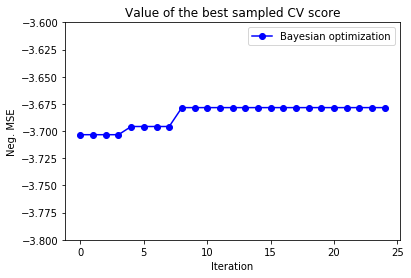

In [23]:
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

# print(f'Baseline neg. MSE = {baseline:.2f}')
print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-3.8, -3.6)
plt.title('Value of the best sampled CV score');
plt.legend();